Import Data + drop the unused columns(Cumulative Entries)

In [1]:
import pandas as pd
df = pd.read_csv('turnstile_170617.txt', parse_dates = [['DATE', 'TIME']])
df.columns = df.columns.str.strip()
df = df.rename(columns = {'ENTRIES': 'CUM_ENTRIES', 'EXITS': 'CUM_EXITS'})
df = df.dropna()
df = df.drop("CUM_ENTRIES", axis=1)
df.head()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,CUM_EXITS
0,2017-06-10 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,2104297
1,2017-06-10 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,2104303
2,2017-06-10 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,2104337
3,2017-06-10 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,2104417
4,2017-06-10 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,2104465


In [2]:
df_copy = df.copy()

In [3]:
#we care about
#C/A + UNIT + STATION refers to a unique turnstile
#SCP denotes the nearby(next to the turnstile) train locations
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197209 entries, 0 to 197208
Data columns (total 9 columns):
DATE_TIME    197209 non-null datetime64[ns]
C/A          197209 non-null object
UNIT         197209 non-null object
SCP          197209 non-null object
STATION      197209 non-null object
LINENAME     197209 non-null object
DIVISION     197209 non-null object
DESC         197209 non-null object
CUM_EXITS    197209 non-null int64
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 9.8+ MB


Create Groupby Object (Each object in the list represents a turnstile)

In [4]:
list_of_df = [g for _, g in df_copy.groupby(['C/A', 'SCP', 'UNIT','STATION'])]
keys = [_ for _,g in df_copy.groupby(['C/A', 'SCP', 'UNIT','STATION'])]
# list_of_df[0]
for i, g in enumerate(list_of_df):
    list_of_df[i].sort_values(by="DATE_TIME", inplace=True)

In [5]:
list_of_df[0].head()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,CUM_EXITS
0,2017-06-10 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,2104297
1,2017-06-10 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,2104303
2,2017-06-10 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,2104337
3,2017-06-10 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,2104417
4,2017-06-10 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,2104465


Adding Amount of People Exiting the Station

In [6]:
for i, x in enumerate(list_of_df):
    ENTRIES = [0]
    EXITS = [0]
    for j in range(len(x.index)):
        if j==0:
            continue
        now = x.iloc[j]
        prev = x.iloc[j-1]
        EXITS.append(now.CUM_EXITS-prev.CUM_EXITS)
    list_of_df[i]['EXITS'] = EXITS
    list_of_df[i]["DATE"] = [d.date() for d in list_of_df[i].DATE_TIME]
    list_of_df[i]["TIME"] = [d.time() for d in list_of_df[i].DATE_TIME]

In [7]:
list_of_df[0].head()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,CUM_EXITS,EXITS,DATE,TIME
0,2017-06-10 00:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,2104297,0,2017-06-10,00:00:00
1,2017-06-10 04:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,2104303,6,2017-06-10,04:00:00
2,2017-06-10 08:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,2104337,34,2017-06-10,08:00:00
3,2017-06-10 12:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,2104417,80,2017-06-10,12:00:00
4,2017-06-10 16:00:00,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,2104465,48,2017-06-10,16:00:00


This is what the data should look like

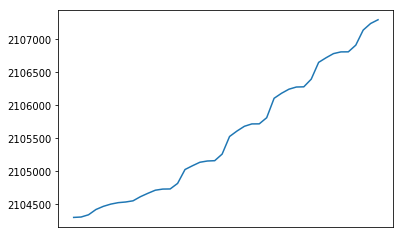

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
x = list_of_df[0].DATE_TIME
y = list_of_df[0].CUM_EXITS
plt.plot(x,y)
plt.xticks([])
plt.show()

Extracting all errors

In [11]:
errors = []
for g in list_of_df:
    temp = g[(g.EXITS > 10000) | (g.EXITS < 0) | ((g.EXITS/g.CUM_EXITS>0.5) & (g.CUM_EXITS>20000))]
    if not temp.empty:
        errors.append(g)
len(errors)

60

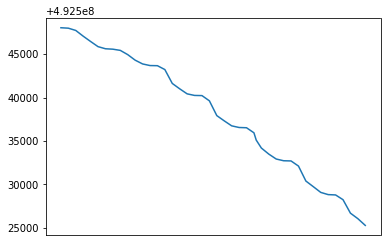

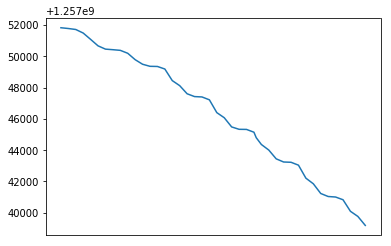

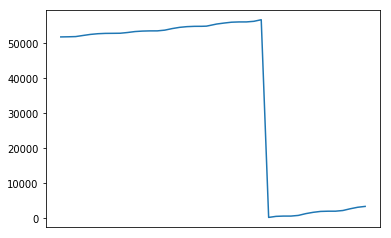

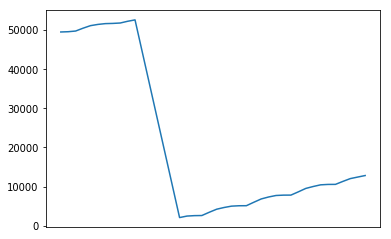

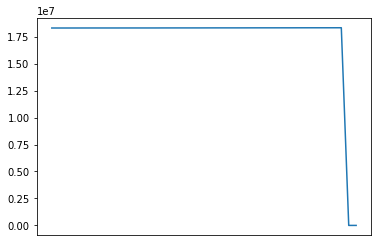

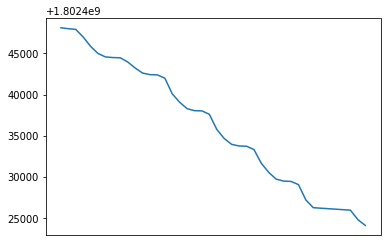

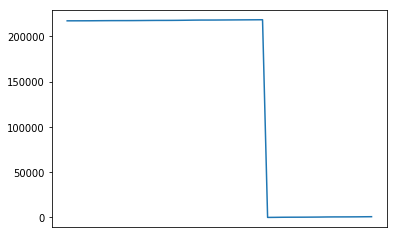

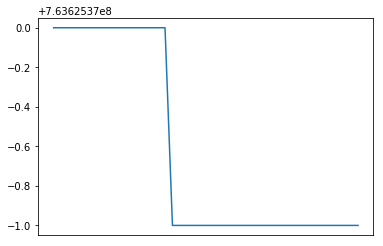

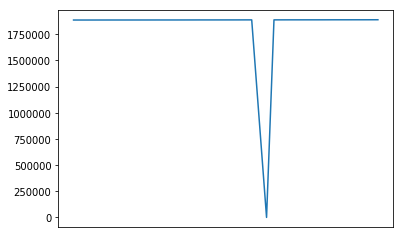

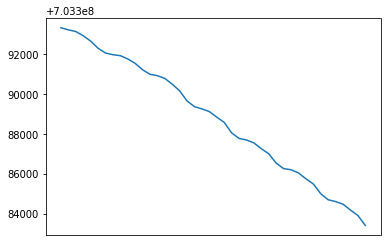

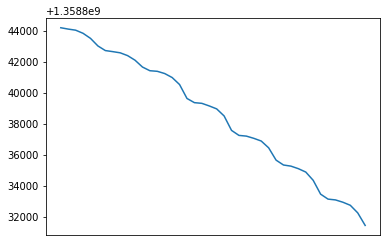

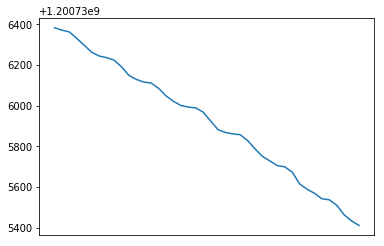

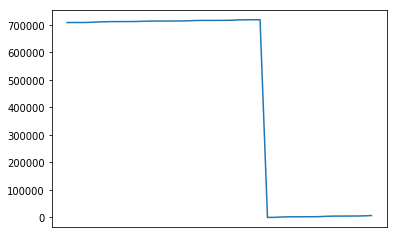

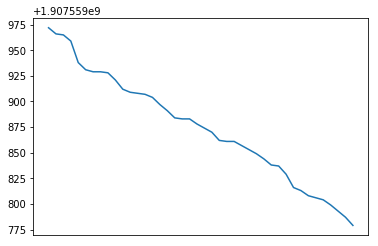

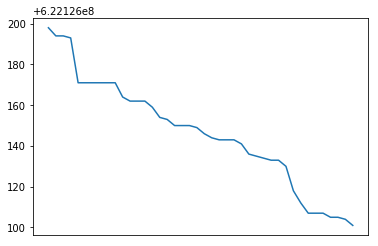

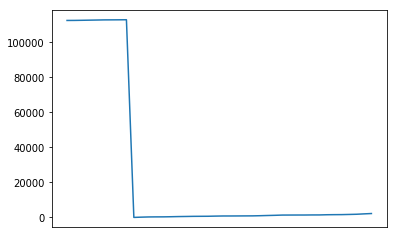

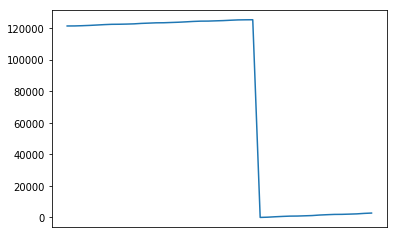

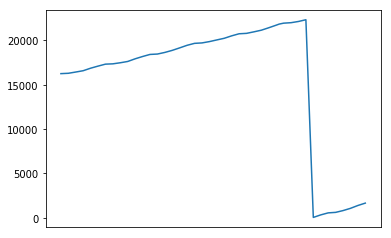

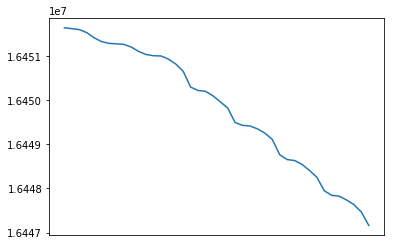

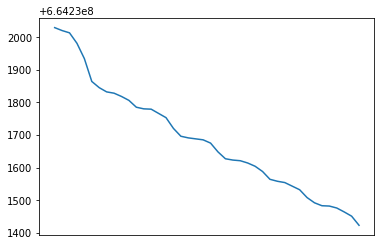

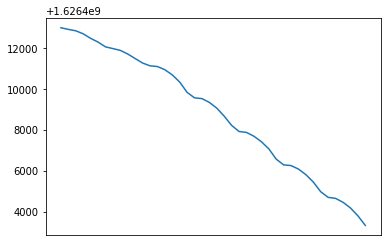

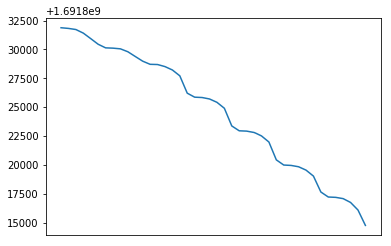

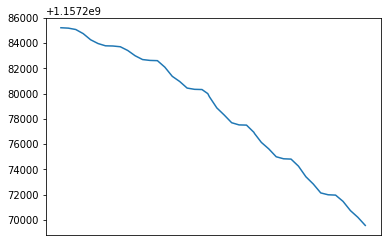

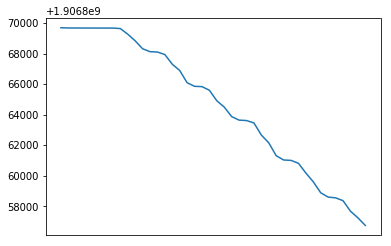

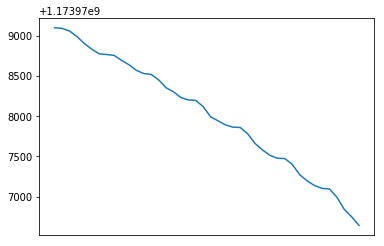

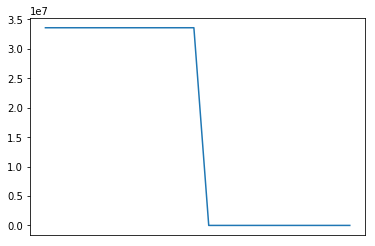

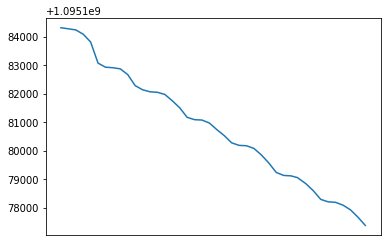

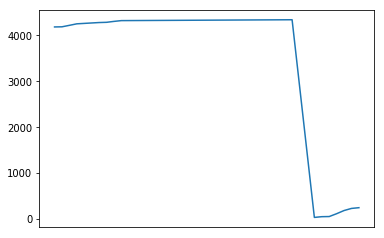

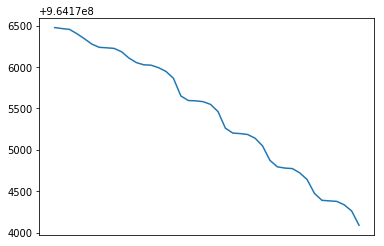

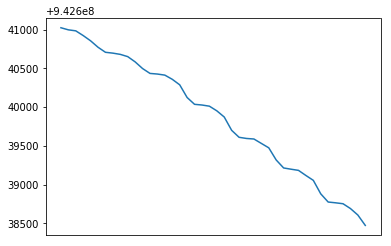

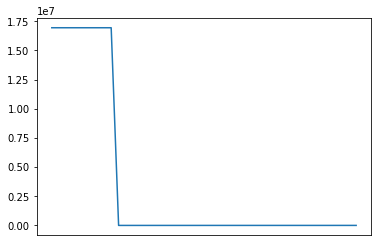

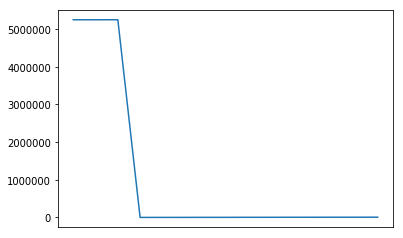

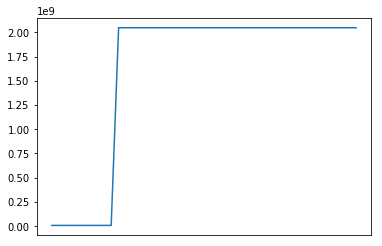

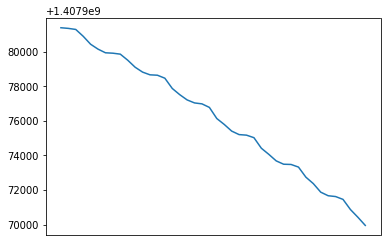

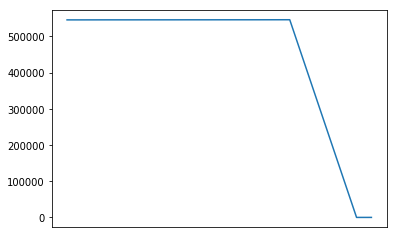

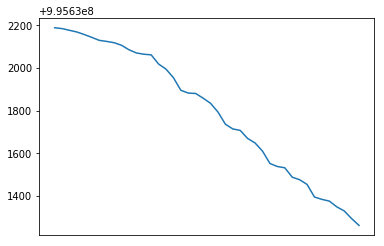

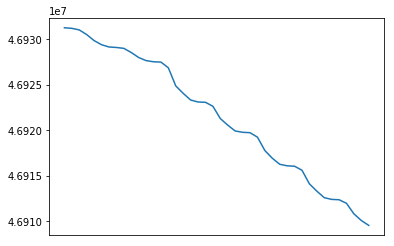

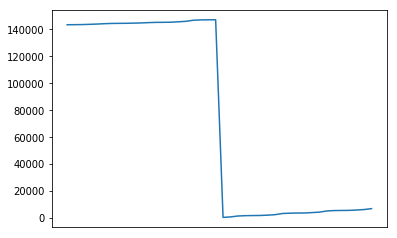

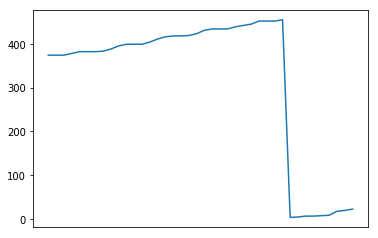

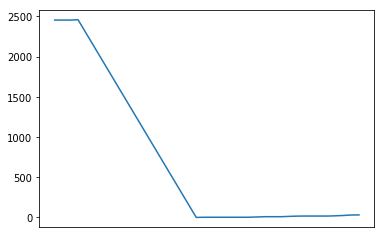

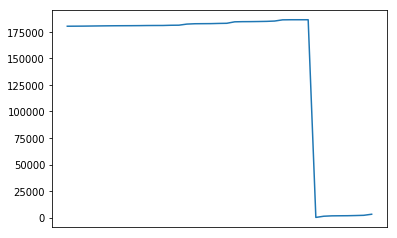

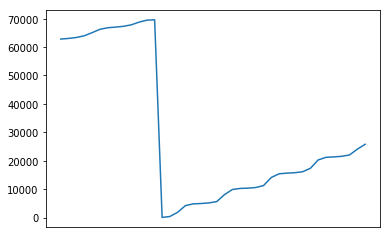

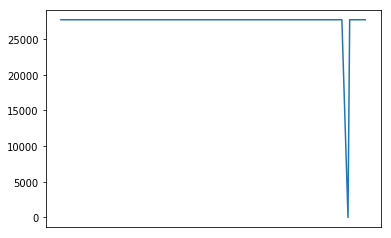

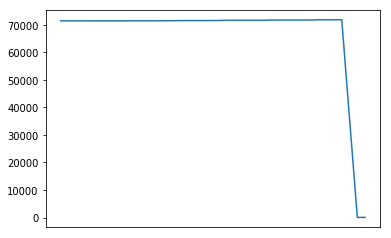

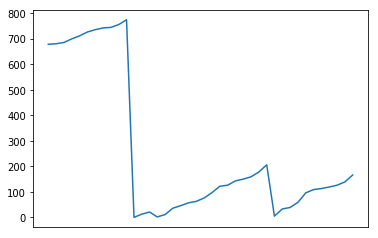

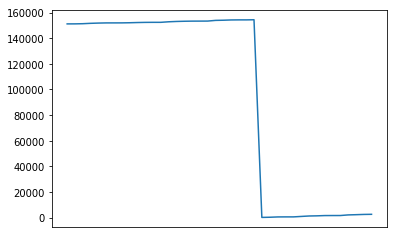

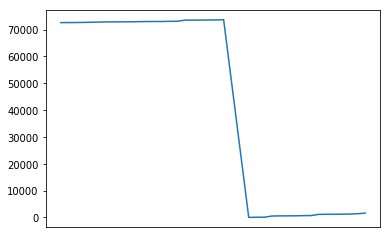

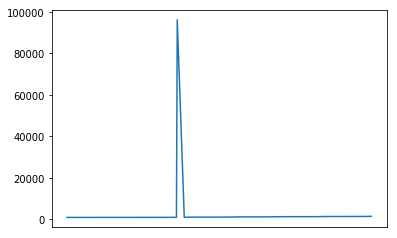

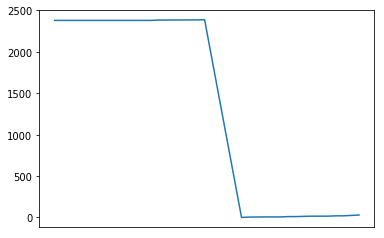

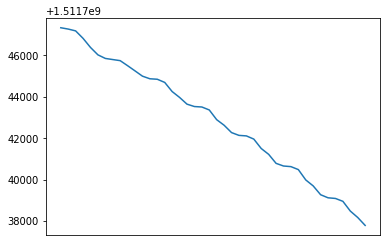

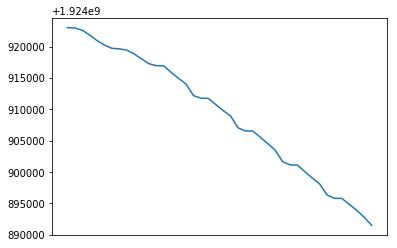

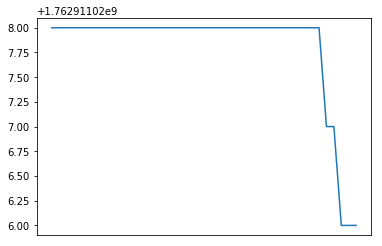

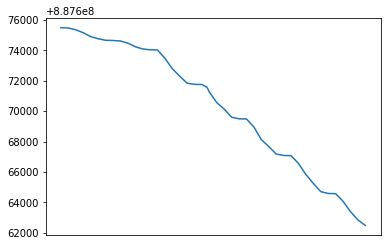

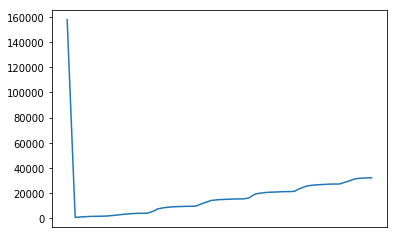

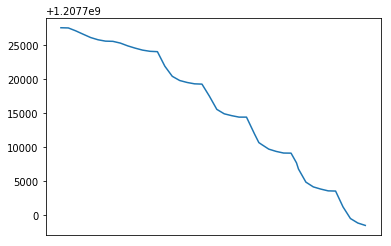

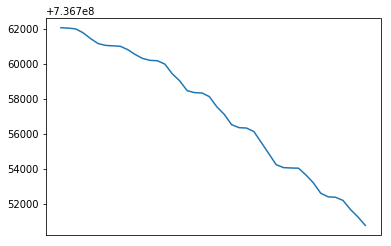

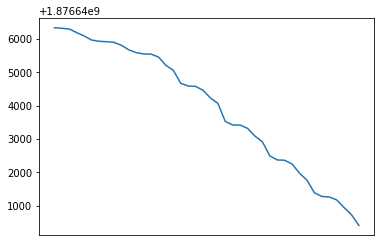

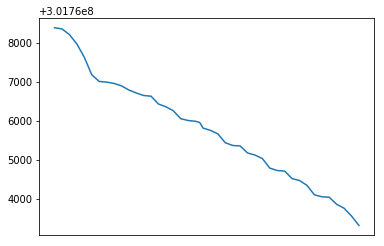

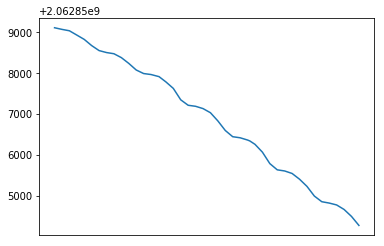

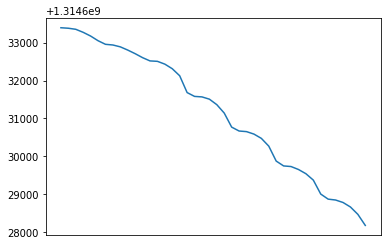

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
for x in errors:
    plt.plot(x.DATE_TIME, x.CUM_EXITS)
    plt.xticks([])
    plt.show()

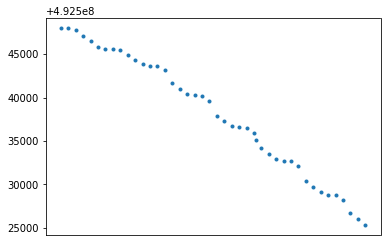

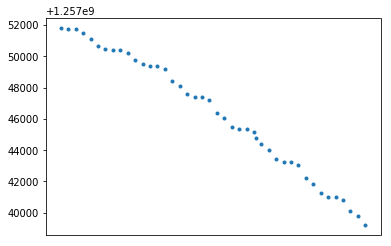

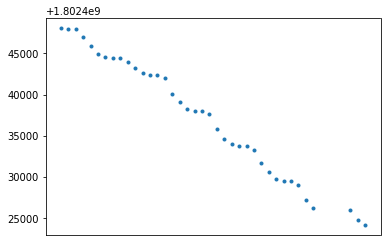

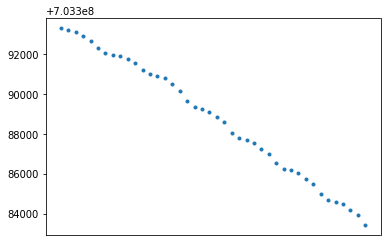

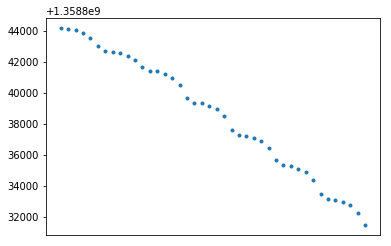

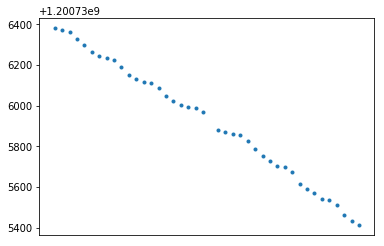

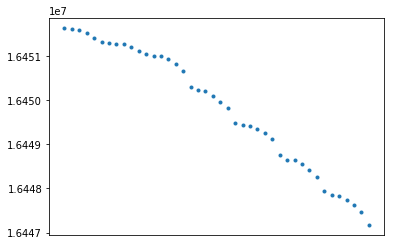

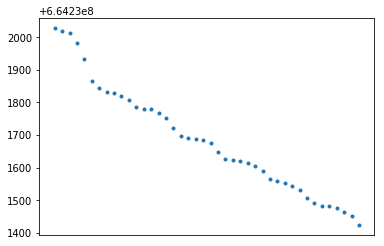

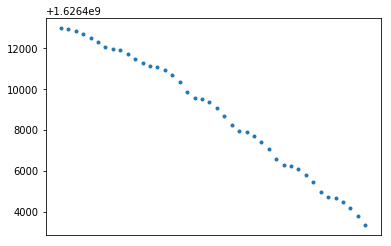

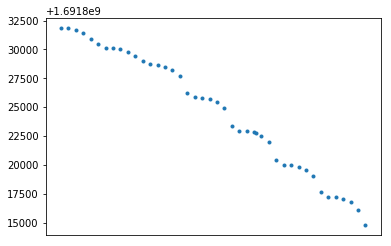

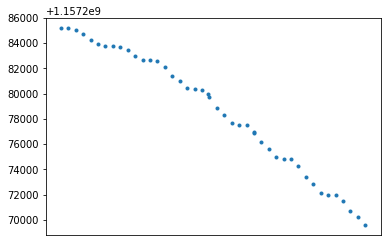

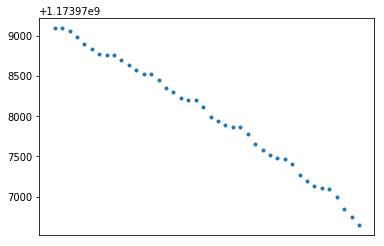

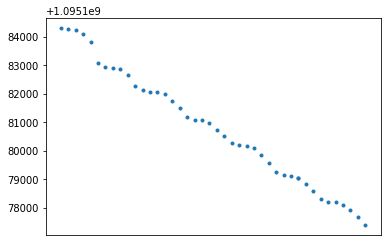

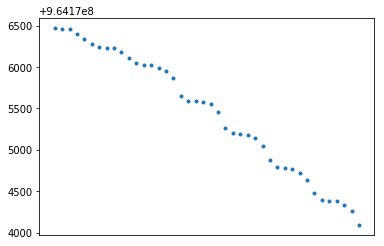

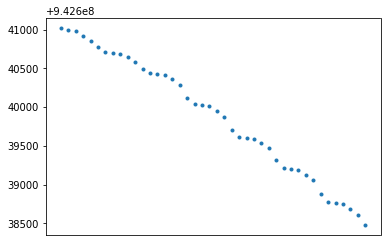

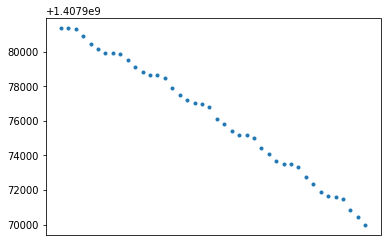

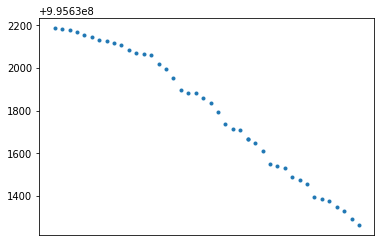

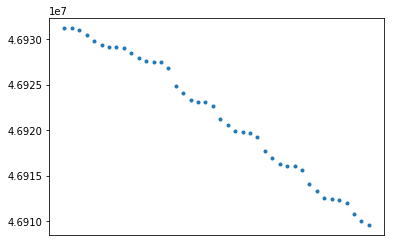

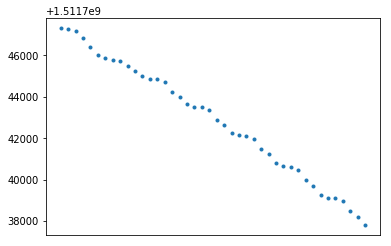

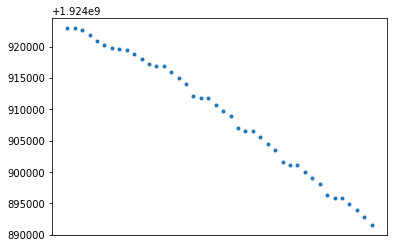

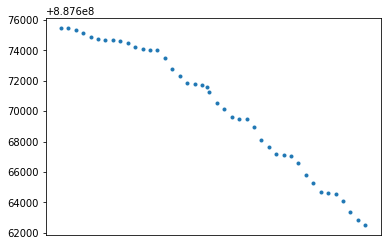

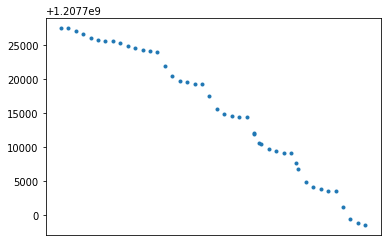

In [ ]:
reflected_exits = []
for x in errors:
    if len(x[x.EXITS < 0]) == len(x)-1:
        reflected_exits.append(x)

for x in reflected_exits:
    plt.plot(x.DATE_TIME, x.CUM_EXITS, '.')
    plt.xticks([])
    plt.show()

In [ ]:
for i, x in enumerate(reflected_exits):
    CUM_EXITS = []
    EXITS = []
    for j in range(len(x.index)):
        if j==0:
            CUM_EXITS.append(x.iloc[j].CUM_EXITS)
            EXITS.append(0)
            continue
        prev = x.iloc[j-1]
        now = x.iloc[j]
        EXITS.append(-now.EXITS)
        CUM_EXITS.append(CUM_EXITS[-1]+EXITS[-1])
    reflected_exits[i].CUM_EXITS = CUM_EXITS
    reflected_exits[i].EXITS = EXITS
for x in reflected_exits:
    plt.plot(x.DATE_TIME, x.CUM_EXITS, '.')
    plt.xticks([])
    plt.show()

Cleanup and get no error dataframe

In [ ]:
noerrors = []
for i, x in enumerate(list_of_df):
    noerrors.append(x[(x.EXITS>0) & ((x.EXITS/x.CUM_EXITS<=0.5) | (x.CUM_EXITS<=20000))])
result = pd.concat(noerrors).sort_values(by="EXITS", ascending=False)

In [ ]:
result = result.drop(['CUM_EXITS'],axis=1)
result.head()

In [ ]:
import pickle
result.to_pickle("No_Errors_Dataset.pkl")

In [14]:
result = pd.read_pickle("No_Errors_Dataset.pkl")
result.sort_values(by="EXITS",ascending=False).head()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,EXITS,DATE,TIME
49047,2017-06-13 20:00:00,N063A,R011,00-00-00,42 ST-PORT AUTH,ACENQRS1237W,IND,REGULAR,4398,2017-06-13,20:00:00
49065,2017-06-15 20:00:00,N063A,R011,00-00-00,42 ST-PORT AUTH,ACENQRS1237W,IND,REGULAR,4252,2017-06-15,20:00:00
49041,2017-06-12 20:00:00,N063A,R011,00-00-00,42 ST-PORT AUTH,ACENQRS1237W,IND,REGULAR,4232,2017-06-12,20:00:00
49059,2017-06-14 20:00:00,N063A,R011,00-00-00,42 ST-PORT AUTH,ACENQRS1237W,IND,REGULAR,4223,2017-06-14,20:00:00
120059,2017-06-15 10:37:10,PTH21,R540,01-00-00,PATH WTC 2,1,PTH,REGULAR,4065,2017-06-15,10:37:10


Generate dictionary containing all the data

In [15]:
alldict = {}
stations = [(_,g) for _,g in result.groupby(["C/A","UNIT","STATION"])]
for k,x in stations:
    scp = [(_,g) for _,g in x.groupby(["SCP"])]
    alldict[k] = {}
    for y,t in scp:
        alldict[k][y] = []
        time_list = t.DATE_TIME.tolist()
        exits_list = t.EXITS.tolist()
        for i in range(len(time_list)):
            alldict[k][y].append((time_list[i],exits_list[i]))
        alldict[k][y].sort(key=lambda x:x[0])
# scp[0][1]
alldict

{('A002',
  'R051',
  '59 ST'): {'02-00-00': [(Timestamp('2017-06-10 04:00:00'), 6),
   (Timestamp('2017-06-10 08:00:00'), 34),
   (Timestamp('2017-06-10 12:00:00'), 80),
   (Timestamp('2017-06-10 16:00:00'), 48),
   (Timestamp('2017-06-10 20:00:00'), 34),
   (Timestamp('2017-06-11 00:00:00'), 22),
   (Timestamp('2017-06-11 04:00:00'), 10),
   (Timestamp('2017-06-11 08:00:00'), 18),
   (Timestamp('2017-06-11 12:00:00'), 63),
   (Timestamp('2017-06-11 16:00:00'), 51),
   (Timestamp('2017-06-11 20:00:00'), 47),
   (Timestamp('2017-06-12 00:00:00'), 17),
   (Timestamp('2017-06-12 04:00:00'), 2),
   (Timestamp('2017-06-12 08:00:00'), 84),
   (Timestamp('2017-06-12 12:00:00'), 211),
   (Timestamp('2017-06-12 16:00:00'), 57),
   (Timestamp('2017-06-12 20:00:00'), 53),
   (Timestamp('2017-06-13 00:00:00'), 19),
   (Timestamp('2017-06-13 04:00:00'), 5),
   (Timestamp('2017-06-13 08:00:00'), 100),
   (Timestamp('2017-06-13 12:00:00'), 267),
   (Timestamp('2017-06-13 16:00:00'), 83),
   (Timesta

Find busiest 4 hrs interval during each day for each station

In [18]:
import datetime
def getPeopleInterval(data, start, end):
    people = 0
    for x in data:
        if start<=x[0]<=end:
            people+=x[1]
    return people
days_range = pd.date_range('2017-06-10',periods=7)
busiest = {}
for key,val in alldict.items():
    busiest[key] = {}
    for x in days_range:
        time_range = pd.date_range(start=x,end=x+datetime.timedelta(hours=20),freq='1H')
        temp = []
        for start in time_range:
            people = 0
            for scp,data in val.items():
                people += getPeopleInterval(data, start, start+datetime.timedelta(hours=4))
            temp.append((people, start))
        busiest[key][x] = sorted(temp,key=lambda x:-x[0])[0]
#         print(temp)

Find busiest stations for each day

In [16]:
station_dict = {}
for _,g in result.groupby(["C/A","UNIT","STATION"]):
    station_dict[_] = pd.DataFrame({'EXITS':g.groupby("DATE").EXITS.sum()})
    station_dict[_] = station_dict[_].reset_index()
station_dict[('A002', 'R051', '59 ST')]

,DATE,EXITS
0,2017-06-10,3971
1,2017-06-11,4023
2,2017-06-12,7159
3,2017-06-13,8834
4,2017-06-14,9139
5,2017-06-15,9122
6,2017-06-16,8654


In [17]:
days = station_dict[('A002', 'R051', '59 ST')]["DATE"].tolist()
each_day = []
for x in days:
    each_day.append([])
    for key,val in station_dict.items():
        if val[val["DATE"] == x].empty:
            continue
        each_day[-1].append((key, int(val[val["DATE"]==x].EXITS)))
for i, x in enumerate(each_day):
    each_day[i].sort(key=lambda x:-x[1])
    print(each_day[i][:5])

[(('H009', 'R235', 'BEDFORD AV'), 32077), (('R238', 'R046', 'GRD CNTRL-42 ST'), 22935), (('N506', 'R022', '34 ST-HERALD SQ'), 20521), (('R533', 'R055', 'FLUSHING-MAIN'), 20110), (('R151', 'R033', 'TIMES SQ-42 ST'), 19585)]
[(('H009', 'R235', 'BEDFORD AV'), 28730), (('R238', 'R046', 'GRD CNTRL-42 ST'), 24190), (('N506', 'R022', '34 ST-HERALD SQ'), 23046), (('R533', 'R055', 'FLUSHING-MAIN'), 21282), (('R151', 'R033', 'TIMES SQ-42 ST'), 20368)]
[(('PTH22', 'R540', 'PATH NEW WTC'), 57296), (('R238', 'R046', 'GRD CNTRL-42 ST'), 52898), (('R240', 'R047', 'GRD CNTRL-42 ST'), 40932), (('R249', 'R179', '86 ST'), 34700), (('R533', 'R055', 'FLUSHING-MAIN'), 28556)]
[(('R238', 'R046', 'GRD CNTRL-42 ST'), 56422), (('PTH22', 'R540', 'PATH NEW WTC'), 54861), (('R240', 'R047', 'GRD CNTRL-42 ST'), 43340), (('R249', 'R179', '86 ST'), 42739), (('R533', 'R055', 'FLUSHING-MAIN'), 30551)]
[(('R238', 'R046', 'GRD CNTRL-42 ST'), 56970), (('PTH22', 'R540', 'PATH NEW WTC'), 54393), (('R240', 'R047', 'GRD CNTRL-

In [29]:
days = pd.date_range('2017-06-10', periods = 7)
for i,x in enumerate(each_day):
    print("Day: %d"%(i+1))
    for station,people in x[:10]:
        print(station, busiest[station][days[i]])

Day: 1
('H009', 'R235', 'BEDFORD AV') (24140, Timestamp('2017-06-10 16:00:00', freq='H'))
('R238', 'R046', 'GRD CNTRL-42 ST') (14077, Timestamp('2017-06-10 16:00:00', freq='H'))
('N506', 'R022', '34 ST-HERALD SQ') (13793, Timestamp('2017-06-10 16:00:00', freq='H'))
('R533', 'R055', 'FLUSHING-MAIN') (12475, Timestamp('2017-06-10 16:00:00', freq='H'))
('R151', 'R033', 'TIMES SQ-42 ST') (14315, Timestamp('2017-06-10 16:00:00', freq='H'))
('N083', 'R138', 'W 4 ST-WASH SQ') (11911, Timestamp('2017-06-10 17:00:00', freq='H'))
('A034', 'R170', '14 ST-UNION SQ') (12240, Timestamp('2017-06-10 17:00:00', freq='H'))
('PTH22', 'R540', 'PATH NEW WTC') (5978, Timestamp('2017-06-10 13:00:00', freq='H'))
('N049', 'R084', '59 ST COLUMBUS') (11323, Timestamp('2017-06-10 16:00:00', freq='H'))
('N324', 'R018', 'JKSN HT-ROOSVLT') (11052, Timestamp('2017-06-10 20:00:00', freq='H'))
Day: 2
('H009', 'R235', 'BEDFORD AV') (16636, Timestamp('2017-06-11 16:00:00', freq='H'))
('R238', 'R046', 'GRD CNTRL-42 ST') (